## Métodos de *ensemble*: *bagging* y *boosting*

Los métodos de *ensemble* consisten en combinar las predicciones de varios modelos para obtener una mejor predicción. Para que la combinación funcione, los modelos tienen que ser diversos, es decir, que aprendan distintos patrones de los datos. Existen dos tipos de modelos de *ensemble* principales:

  * **Modelos independientes**, donde cada modelo se construye por separado y finalmente se combinan las predicciones (por ejemplo Random Forest). En media el modelo combinado es mejor que cualquiera de los modelos individuales porque reducimos su varianza.
  
  
  * **Modelos secuenciales**, donde cada modelo se va construyendo de forma secuencial para mejorar las predicciones del anterior (por ejemplo Gradient Boosting)

[Ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html)

### Random Forest

Combina árboles de decisión. Para obtener diversidad, introduce dos fuentes de aleatoriedad:

   * *bagging* (*bootstrap aggregating*), donde cada árbol se ajusta con una muestra *boostrap* de los datos
   
   
   * para realizar cada partición en un árbol se elige una muestra aleatoria de las variables
   
*Bootstrap* es una técnica donde se generar muestras **con reemplazamiento** de los datos originales (del mismo tamaño). Estas muestras tendrán ejemplos repetidos (en media un 63% de ejemplos distintos), pero hace que cada árbol del conjunto se "especialice" en una parte de los datos.

<img src=../../img/bagging.png width=600>

  * En un problema de  **clasificación**, combinamos las predicciones finales usando el voto de la mayoría

  * En un problema de **regresión**, combinamos las predicciones usando la media
  
<img src=https://amueller.github.io/ml-workshop-2-of-4/slides/images/random_forest.png width=600>

Comparados con los árboles de decisión:

  * Perdemos capacidad de interpretación, ya que no tenemos disponibles las reglas que predicen una muestra
  
  * Mejoran notablemente el error de predicción
  
  * Menos sensibles al sobreajuste (la aleatorización introduce un sesgo pero reduce bastante más la varianza)

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=0)

In [2]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train)

1.0

In [3]:
rfc.score(X_test, y_test)

0.972027972027972

#### Selección de parámetros

Las clases `RandomForestRegressor` y `RandomForestClassifier` tienen múltiples parámetros, pero los principales son:

  * `n_estimators`, número de árboles. En general cuanto más grande mejor si se escogen bien el resto de parámetros, puede tener impacto en el tiempo de entrenamiento
  
  
  * `max_features`, número de variables que se consideran de forma aleatoria para hacer cada partición. Parámetro importante
  
  
  * `max_depth`, profundidad máxima
  
  
  * `min_samples_split`, número mínimo de ejemplos para particionar un nodo
  
  
  * `min_samples_leaf`, número mínimo de ejemplos de una hoja, si una partición va a dejar menos en el lado izquierdo o derecho no se hace
  

  * `max_leaf_nodes`, número máximo de nodos hoja
  
Los últimos 4 parámetros controlan la profundidad (complejidad) de los árboles. Escoger 2 o 3 y buscar sus valores óptimos usando validación cruzada

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

param_grid = { 
    'n_estimators': [100, 200],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [None, 2, 4],
    'min_samples_split': [2, 3, 4]
}

cv = GridSearchCV(estimator=rfc, 
                  param_grid=param_grid, 
                  cv=5, 
                  scoring='accuracy', 
                  return_train_score=False)

cv.fit(X_train, y_train)

print(cv.best_params_)
print(cv.score(X_test, y_test))

{'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
0.972027972027972


In [5]:
import pandas as pd

cv_res = pd.DataFrame(cv.cv_results_).sort_values(by='mean_test_score', ascending=False)

cv_res[[*cv_res.columns[cv_res.columns.str.startswith("param_")], 'mean_test_score']].head()

,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,mean_test_score
12,None,log2,2,100,0.960137
15,None,log2,3,200,0.955404
53,4,log2,4,200,0.953051
46,4,sqrt,4,100,0.953051
10,None,sqrt,4,100,0.953051


Como se puede ver, el número de modelos que hay que ajustar aumenta exponencialmente cuando se añaden parámetros. En este ejemplo estamos ajustando $2 \times 3 \times 3 \times 3 = 54$ modelos.

Una alternativa es usar `RandomizedSearchCV`, donde se indica un límite (por ejemplo `n_iter=20`) y prueba combinaciones aleatorias hasta alcanzar ese límite.

#### Interpretación

Al igual que los árboles de decisión, la implementación de *random forest* en scikit-learn devuelve la importancia de cada una de las variables. Sin embargo, esta medida está calculada sobre el conjunto de entrenamiento y por tanto puede ser alta incluso para variables no muy relacionadas con la salida.

Una alternativa implementada en scikit-learn es la función `permutation_importance`:

   * Calcular el error base
   
   
   * Permutar aleatoriamente los valores de una variable
   
   
   * Calcular la diferencia con el error base
       1. si la diferencia es muy grande (el error aumenta mucho), quiere decir que esa variable era importante
       
       2. si la diferencia es pequeña (el error apenas cambia), quiere decir que esa variable apenas tiene relación con la salida


Más información:

  * [Permutation Importance vs Random Forest Feature Importance (MDI)](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)

  * [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

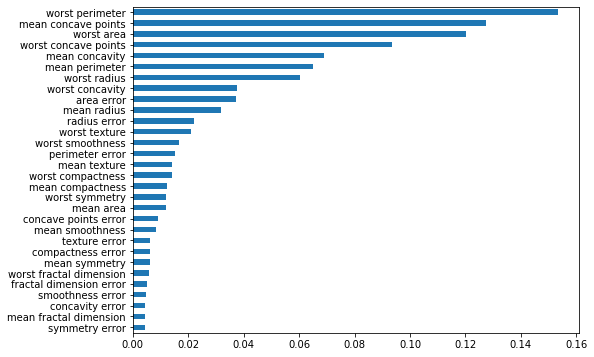

In [6]:
(pd.Series(cv.best_estimator_.feature_importances_, index=data.feature_names)
   .sort_values()
   .plot(kind='barh', figsize=(8, 6)));

In [7]:
from sklearn.inspection import permutation_importance

result = permutation_importance(cv.best_estimator_, X_test, y_test, n_repeats=10, random_state=0)

In [8]:
sorted_idx = result['importances_mean'].argsort()
imp = pd.DataFrame(result['importances'].T, columns=data.feature_names)
imp.T.head()

,0,1,2,3,4,5,6,7,8,9
mean radius,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mean texture,0.000000,0.006993,0.0,0.013986,0.006993,0.020979,0.013986,0.013986,0.013986,0.013986
mean perimeter,0.006993,0.000000,0.0,0.006993,0.000000,0.006993,0.006993,0.006993,0.006993,0.006993
mean area,0.006993,0.000000,0.0,0.006993,0.000000,0.006993,0.006993,0.013986,0.006993,0.006993
mean smoothness,0.000000,0.000000,0.0,0.000000,0.000000,0.006993,-0.006993,-0.006993,0.000000,-0.006993


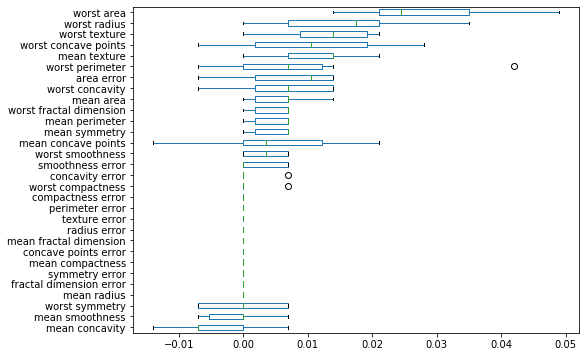

In [9]:
imp.iloc[:, sorted_idx].plot(kind='box', vert=False, figsize=(8, 6));

### Gradient Boosting

Random forest
  
  * Disponible para regresión y clasificación
  
  * No lineal
  
  * Usa árboles de decisión 
  
  * Ajusta todos los modelos de forma independiente, en paralelo. Finalmente combina las predicciones
  
  * Muy robusto
  
Gradient boosting

  * Disponible para regresión y clasificación
  
  * No lineal
  
  * Usa árboles de decisión 
  
  * Ajusta todos los modelos de forma secuencial, intentando **corregir** las predicciones del modelo anterior
  
  * En general más precisión que Random Forest, pero hay que ajustar los parámetros con cuidado

[How to explain gradient boosting](https://explained.ai/gradient-boosting/index.html)

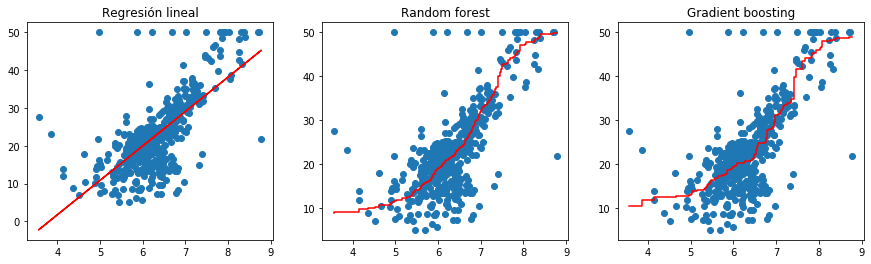

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

boston = load_boston()

data = pd.DataFrame(boston.data, columns=boston.feature_names)
data['MEDV'] = boston.target

x = data[['RM']]
y = data['MEDV']

lm = LinearRegression()
lm.fit(x, y)

rfr = RandomForestRegressor()
rfr.fit(x, y)

gbr = GradientBoostingRegressor()
gbr.fit(x, y)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(x, y)
axes[0].plot(x, lm.predict(x), 'r')
axes[0].set_title('Regresión lineal')

axes[1].scatter(x, y)
axes[1].step(np.sort(x['RM'].values), np.sort(rfr.predict(x)), 'r')
axes[1].set_title('Random forest')

axes[2].scatter(x, y)
axes[2].step(np.sort(x['RM'].values), np.sort(gbr.predict(x)), 'r')
axes[2].set_title('Gradient boosting');

Los modelos se ajustan de forma secuencial:

  * $f_1(x) \approx y$
  
  
  * $f_2(x) \approx y - f_1(x)$
  
  
  * $f_3(x) \approx y - f_1(x) - f_2(x)$
  
  
  * ...

Visualmente:

<img src=https://amueller.github.io/ml-workshop-3-of-4/slides/images/grad_boost_regression_steps.png width=500>

#### Implementaciones scikit-learn

Clases:

  * `GradientBoosting`

  * `HistGradientBoosting`, implementación basada en LightGBM, más rapida y gestiona valores que falta directamente

Parámetros:

  1. Parámetros que comparte con *random forest*:

     * `n_estimators`, número de árboles. En general cuanto más grande mejor si se escogen bien el resto de parámetros, puede tener impacto en el tiempo de entrenamiento
     * `max_features`, número de variables que se consideran de forma aleatoria para hacer cada partición. Parámetro importante
     * `max_depth`, profundidad máxima
     * `min_samples_split`, número mínimo de ejemplos para particionar un nodo
     * `min_samples_leaf`, número mínimo de ejemplos de una hoja, si una partición va a dejar menos en el lado izquierdo o derecho no se hace
     * `max_leaf_nodes`, número máximo de nodos hoja
     
     
  2. Otros parámetros:
  
     * `subsampling`, fracción de muestras a usar para ajustar cada uno de los modelos individuales
     * `learning_rate`, reduce la contribución de cada uno de los árboles
     * `n_iter_no_change`, porcentaje de los datos para crear un conjunto de validación y parar el entrenamiento antes de tiempo cuando no mejore el error (se ajustan menos de `n_estimators` modelos)

*Gradient boosting* puede hacer sobreajuste al añadir más estimadores. Dos opciones:

  * Elegir `n_estimators`, buscar el valor de `learning_rate`
  
  * Elegir `learning_rate`, parar el entrenamiento antes de tiempo con `n_iter_no_change`

Además, es recomendable ajustar el valor de `max_features`, `subsampling` y `max_depth` como mínimo.

[Gradient Boosting regularization](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regularization.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regularization-py)

In [11]:
from sklearn.model_selection import train_test_split

X, y = load_boston(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

lm = LinearRegression()
lm.fit(X_train, y_train)
print('Regresión lineal: ', lm.score(X_test, y_test))

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
print('Random forest: ', rfr.score(X_test, y_test))

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
print('Gradient boosting: ', gbr.score(X_test, y_test))

Regresión lineal:  0.6354638433202129
Random forest:  0.8055534566183848
Gradient boosting:  0.8289980261143337


#### Otras implementaciones de gradient boosting

 * [XGBoost](https://xgboost.readthedocs.io/en/latest/) (2014)
 * [LightGBM](https://lightgbm.readthedocs.io/en/latest/) (Microsoft, 2017)
 * [CatBoost](https://catboost.ai/) (Yandex, 2017)
 
Todas las librerías cuentan con una API compatible con scikit-learn, aunque el nombre/significado de los hiper-parámetros puede variar.

Existen múltiples comparaciones recientes, por ejemplo:
  
  * [XGBoost, LightGBM or CatBoost — which boosting algorithm should I use?](https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc)
  
  * [Boosting Showdown: Scikit-Learn vs XGBoost vs LightGBM vs CatBoost in Sentiment Classification](https://towardsdatascience.com/boosting-showdown-scikit-learn-vs-xgboost-vs-lightgbm-vs-catboost-in-sentiment-classification-f7c7f46fd956)
  
  * [CatBoost vs. Light GBM vs. XGBoost](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)
  
  * [Comparison between XGBoost, LightGBM and CatBoost Using a Home Credit Dataset](https://pdfs.semanticscholar.org/b992/fdb71b4b78d7b81dc3761402f4eb446077c2.pdf)
  
En general: 

  * XGBoost fue el primero, precisión bastante alta
  
  * LightGBM suele ser el más rápido, a costa de una ligera disminución de precisión comparado con XGBoost
  
  * CatBoost es una opción interesante cuando hay muchas variables categóricas

In [12]:
#%conda install -c conda-forge xgboost

from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.7476326720496416

### Ejercicios

#### Ejercicio 1

* Con los datos de `adult` comparar el rendimiento de un *random forest* con el de un arbol de decisión

* Buscar los parámetros óptimos para ese conjunto de datos usando validación cruzada (prueba como mínimo con `meax_leaf_nodes` y `max_depth`)

#### Ejercicio 2

* Ajustar ahora un Random Forest y Gradient Boosting para el problema de regresión `bike_day_raw.csv`:

  1. En random forest busca los parámetros `max_leaf_nodes` y `max_depth`
  2. En gradient boosting busca `learning_rate` y `max_depth`


* Compara la importancia de las variables entre Random Forest, Gradient Boosting y usando la función `permutation_importance`
